## Setup and Imports

In [2]:

import os
import sys
import json
from datetime import datetime
from pathlib import Path

import numpy as np
import polars as pl
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, precision_recall_curve,
    average_precision_score
)

from sentence_transformers import SentenceTransformer
import optuna
from optuna.integration.wandb import WeightsAndBiasesCallback
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
sys.path.append(str(Path.cwd().parent.parent))

from app.data_processing.preprocessing_pipeline import PreprocessingPipeline



print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")
print(f"Optuna version: {optuna.__version__}")



PyTorch version: 2.5.1+cu121
CUDA available: True
Device: cuda
Optuna version: 4.6.0


## Configuration

In [3]:
config = {
    "random_seed": 42,
    "data_source": "../../emails_v6.parquet",
    "numeric_features": [
        "sender_domain_entropy", "has_attachment",
        "spf_flag_missing", "dkim_flag_missing",
        "num_links", "subject_length", "body_length", "keyword_count", 
        "num_received_headers", "num_exclamation_marks", 
        "num_malicious_links"
    ],
    "embedding_model": "all-MiniLM-L6-v2",
    "embedding_dim": 384,
    "n_trials": 30
}
wandb.login()
wandb.init(project="mlp-model-tuning", config=config)

wandb: Currently logged in as: latandu (latandu-phishstop) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Load and Split Data

In [4]:

df = pl.read_parquet(config["data_source"])
df = PreprocessingPipeline().process_pipeline(df)

external_df = df.filter(
    (pl.col("source") == "data/csv_misc/TREC-07.csv") | 
    (pl.col("source") == "phishing-2020")
)

train_pool_df = df.filter(
    (pl.col("source") != "data/csv_misc/TREC-07.csv") & 
    (pl.col("source") != "phishing-2020")
)

train_pool_pd = train_pool_df.to_pandas()

train_val_df_pd, test_df_pd = train_test_split(
    train_pool_pd, 
    test_size=0.2, 
    random_state=config["random_seed"], 
    stratify=train_pool_pd['phishing']
)

train_df_pd, val_df_pd = train_test_split(
    train_val_df_pd,
    test_size=0.2,
    random_state=config["random_seed"],
    stratify=train_val_df_pd['phishing']
)

train_df = pl.from_pandas(train_df_pd)
val_df = pl.from_pandas(val_df_pd)
test_df = pl.from_pandas(test_df_pd)

print(f"Final splits:")
print(f"Train: {len(train_df):,} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Validation: {len(val_df):,} ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test: {len(test_df):,} ({len(test_df)/len(df)*100:.1f}%)")
print(f"External: {len(external_df):,} ({len(external_df)/len(df)*100:.1f}%)")

numeric_features = config["numeric_features"]

features_train = train_df.select(numeric_features).fill_null(0).to_numpy()
features_val = val_df.select(numeric_features).fill_null(0).to_numpy()
features_test = test_df.select(numeric_features).fill_null(0).to_numpy()
features_external = external_df.select(numeric_features).fill_null(0).to_numpy()

y_train = train_df['phishing'].to_numpy()
y_val = val_df['phishing'].to_numpy()
y_test = test_df['phishing'].to_numpy()
y_external = external_df['phishing'].to_numpy()

Final splits:
Train: 101,649 (47.9%)
Validation: 25,413 (12.0%)
Test: 31,766 (15.0%)
External: 53,285 (25.1%)


## Generate Embeddings

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
embedding_model = SentenceTransformer(config["embedding_model"], device=device)

X_emb_train = embedding_model.encode(
    train_df['body_subject'].to_list(), 
    show_progress_bar=True, 
    convert_to_numpy=True,
    batch_size=32
)

X_emb_val = embedding_model.encode(
    val_df['body_subject'].to_list(), 
    show_progress_bar=True, 
    convert_to_numpy=True,
    batch_size=32
)

X_emb_test = embedding_model.encode(
    test_df['body_subject'].to_list(), 
    show_progress_bar=True, 
    convert_to_numpy=True,
    batch_size=32
)

X_emb_external = embedding_model.encode(
    external_df['body_subject'].to_list(), 
    show_progress_bar=True, 
    convert_to_numpy=True,
    batch_size=32
)

print(f"Embedding shapes:")
print(f"Train: {X_emb_train.shape}")
print(f"Validation: {X_emb_val.shape}")
print(f"Test: {X_emb_test.shape}")
print(f"External: {X_emb_external.shape}")

Batches: 100%|██████████| 3177/3177 [02:22<00:00, 22.35it/s] 

Batches: 100%|██████████| 795/795 [00:41<00:00, 19.06it/s]

Batches: 100%|██████████| 993/993 [00:53<00:00, 18.49it/s] 

Batches: 100%|██████████| 1666/1666 [01:36<00:00, 17.21it/s]



Embedding shapes:
Train: (101649, 384)
Validation: (25413, 384)
Test: (31766, 384)
External: (53285, 384)


## Hyperparameter Tuning with Optuna

In [6]:
from hybrid_mlp_model import HybridMLPClassifier

def mlp_objective(trial):
    params = {
        'feature_hidden_dim': trial.suggest_categorical('feature_hidden_dim', [16, 32, 64, 128]),
        'dropout': trial.suggest_float('dropout', 0.1, 0.5, step=0.1),
        'lr': trial.suggest_float('lr', 1e-4, 1e-2, log=True),
        'weight_decay': trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128]),
        'pos_weight': trial.suggest_float('pos_weight', 1.0, 10.0, step=0.5),
        'threshold': trial.suggest_float('threshold', 0.2, 0.5, step=0.05)
    }
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = HybridMLPClassifier(
        embedding_dim=config["embedding_dim"],
        num_features=len(numeric_features),
        feature_hidden_dim=params['feature_hidden_dim'],
        dropout=params['dropout']
    ).to(device)
    
    train_loader = DataLoader(
        TensorDataset(
            torch.FloatTensor(X_emb_train),
            torch.FloatTensor(features_train),
            torch.FloatTensor(y_train)
        ),
        batch_size=params['batch_size'],
        shuffle=True
    )
    
    val_loader = DataLoader(
        TensorDataset(
            torch.FloatTensor(X_emb_val),
            torch.FloatTensor(features_val),
            torch.FloatTensor(y_val)
        ),
        batch_size=params['batch_size'],
        shuffle=False
    )
    
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=params['lr'],
        weight_decay=params['weight_decay']
    )
    
    criterion = nn.BCEWithLogitsLoss(
        pos_weight=torch.tensor([params['pos_weight']], device=device)
    )
    
    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(30):
        model.train()
        for embeddings, features, labels in train_loader:
            embeddings, features, labels = embeddings.to(device), features.to(device), labels.to(device)
            
            optimizer.zero_grad()
            logits = model(embeddings, features).squeeze()
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for embeddings, features, labels in val_loader:
                embeddings, features, labels = embeddings.to(device), features.to(device), labels.to(device)
                logits = model(embeddings, features).squeeze()
                val_loss += criterion(logits, labels).item()
        
        val_loss /= len(val_loader)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
    
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        model.to(device)
    
    model.eval()
    val_probs = []
    val_labels = []
    
    with torch.no_grad():
        for embeddings, features, labels in val_loader:
            embeddings, features = embeddings.to(device), features.to(device)
            logits = model(embeddings, features).squeeze()
            probs = torch.sigmoid(logits)
            
            if probs.dim() == 0:
                val_probs.append(probs.cpu().item())
                val_labels.append(labels.item())
            else:
                val_probs.extend(probs.cpu().numpy())
                val_labels.extend(labels.numpy())
    
    val_probs = np.array(val_probs)
    val_labels = np.array(val_labels)
    val_preds = (val_probs >= params['threshold']).astype(int)
    
    recall = recall_score(val_labels, val_preds, zero_division=0)
    precision = precision_score(val_labels, val_preds, zero_division=0)
    f1 = f1_score(val_labels, val_preds, zero_division=0)
    roc_auc = roc_auc_score(val_labels, val_probs)
    
    trial.set_user_attr('recall', recall)
    trial.set_user_attr('precision', precision)
    trial.set_user_attr('f1_score', f1)
    trial.set_user_attr('roc_auc', roc_auc)
    
    if precision + recall > 0:
        F2 = (5 * precision * recall) / (4 * precision + recall)
    else:
        F2 = 0
    return F2

In [7]:
wandb_callback = WeightsAndBiasesCallback(
    metric_name="objective_score",
    wandb_kwargs={"project": "phishstop-mlp", "tags": ["optuna", "mlp"]}
)

study = optuna.create_study(
    direction="maximize",
    study_name="mlp-tuning",
    sampler=optuna.samplers.TPESampler(seed=42)
)

study.optimize(
    mlp_objective,
    n_trials=config["n_trials"],
    callbacks=[wandb_callback],
    show_progress_bar=True
)

print(f"Best hyperparameters:")
print(f"F2 Score: {study.best_trial.value:.4f}")
print(f"Recall: {study.best_trial.user_attrs['recall']:.4f}")
print(f"ROC-AUC: {study.best_trial.user_attrs['roc_auc']:.4f}")
print(f"Precision: {study.best_trial.user_attrs['precision']:.4f}")
print(f"F1: {study.best_trial.user_attrs['f1_score']:.4f}")
print(f"Best params:")
for k, v in study.best_trial.params.items():
    print(f"  {k}: {v}")

C:\Users\Latandu\AppData\Local\Temp\ipykernel_28620\1848472119.py:1: ExperimentalWarning: WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.
  wandb_callback = WeightsAndBiasesCallback(


[I 2025-12-02 14:00:19,954] A new study created in memory with name: mlp-tuning
Best trial: 0. Best value: 0.976311:   3%|▎         | 1/30 [01:46<51:29, 106.55s/it]

[I 2025-12-02 14:02:06,501] Trial 0 finished with value: 0.9763112086581398 and parameters: {'feature_hidden_dim': 32, 'dropout': 0.1, 'lr': 0.00020511104188433984, 'weight_decay': 1.3066739238053272e-05, 'batch_size': 32, 'pos_weight': 1.0, 'threshold': 0.5}. Best is trial 0 with value: 0.9763112086581398.


Best trial: 1. Best value: 0.978306:   7%|▋         | 2/30 [02:36<34:10, 73.23s/it] 

[I 2025-12-02 14:02:56,404] Trial 1 finished with value: 0.978305553479333 and parameters: {'feature_hidden_dim': 16, 'dropout': 0.2, 'lr': 0.0011207606211860567, 'weight_decay': 7.309539835912905e-05, 'batch_size': 64, 'pos_weight': 3.5, 'threshold': 0.30000000000000004}. Best is trial 1 with value: 0.978305553479333.


Best trial: 1. Best value: 0.978306:  10%|█         | 3/30 [03:58<34:42, 77.14s/it]

[I 2025-12-02 14:04:18,197] Trial 2 finished with value: 0.9761204586063132 and parameters: {'feature_hidden_dim': 32, 'dropout': 0.30000000000000004, 'lr': 0.0001238513729886094, 'weight_decay': 0.000164092867306479, 'batch_size': 128, 'pos_weight': 10.0, 'threshold': 0.45}. Best is trial 1 with value: 0.978305553479333.


Best trial: 3. Best value: 0.978605:  13%|█▎        | 4/30 [05:16<33:39, 77.67s/it]

[I 2025-12-02 14:05:36,685] Trial 3 finished with value: 0.9786050171422149 and parameters: {'feature_hidden_dim': 64, 'dropout': 0.1, 'lr': 0.0009780337016659412, 'weight_decay': 1.1715937392307055e-05, 'batch_size': 32, 'pos_weight': 3.5, 'threshold': 0.35000000000000003}. Best is trial 3 with value: 0.9786050171422149.


Best trial: 3. Best value: 0.978605:  17%|█▋        | 5/30 [06:59<36:09, 86.79s/it]

[I 2025-12-02 14:07:19,649] Trial 4 finished with value: 0.9616578556243298 and parameters: {'feature_hidden_dim': 64, 'dropout': 0.5, 'lr': 0.006161049539380964, 'weight_decay': 0.0001569639638866114, 'batch_size': 32, 'pos_weight': 1.0, 'threshold': 0.30000000000000004}. Best is trial 3 with value: 0.9786050171422149.


Best trial: 5. Best value: 0.97909:  20%|██        | 6/30 [07:35<27:46, 69.43s/it] 

[I 2025-12-02 14:07:55,391] Trial 5 finished with value: 0.9790895840340845 and parameters: {'feature_hidden_dim': 64, 'dropout': 0.2, 'lr': 0.001217284708112243, 'weight_decay': 1.913588048769229e-05, 'batch_size': 128, 'pos_weight': 8.0, 'threshold': 0.25}. Best is trial 5 with value: 0.9790895840340845.


Best trial: 6. Best value: 0.979304:  23%|██▎       | 7/30 [09:22<31:20, 81.76s/it]

[I 2025-12-02 14:09:42,519] Trial 6 finished with value: 0.979304419290971 and parameters: {'feature_hidden_dim': 32, 'dropout': 0.4, 'lr': 0.00014063366777718192, 'weight_decay': 5.211124595788268e-05, 'batch_size': 64, 'pos_weight': 4.0, 'threshold': 0.2}. Best is trial 6 with value: 0.979304419290971.


Best trial: 6. Best value: 0.979304:  27%|██▋       | 8/30 [10:18<26:55, 73.45s/it]

[I 2025-12-02 14:10:38,180] Trial 7 finished with value: 0.9757253582647164 and parameters: {'feature_hidden_dim': 64, 'dropout': 0.5, 'lr': 0.0008798929749689024, 'weight_decay': 1.7345566642360933e-05, 'batch_size': 64, 'pos_weight': 8.0, 'threshold': 0.35000000000000003}. Best is trial 6 with value: 0.979304419290971.


Best trial: 8. Best value: 0.97987:  30%|███       | 9/30 [11:08<23:10, 66.21s/it] 

[I 2025-12-02 14:11:28,470] Trial 8 finished with value: 0.9798696896655619 and parameters: {'feature_hidden_dim': 16, 'dropout': 0.1, 'lr': 0.0018742210985555703, 'weight_decay': 4.253162363790868e-05, 'batch_size': 64, 'pos_weight': 4.5, 'threshold': 0.45}. Best is trial 8 with value: 0.9798696896655619.


Best trial: 8. Best value: 0.97987:  33%|███▎      | 10/30 [12:39<24:36, 73.85s/it]

[I 2025-12-02 14:12:59,422] Trial 9 finished with value: 0.9640357805411165 and parameters: {'feature_hidden_dim': 64, 'dropout': 0.5, 'lr': 0.004132765459466363, 'weight_decay': 0.00018484491720988634, 'batch_size': 32, 'pos_weight': 9.0, 'threshold': 0.35000000000000003}. Best is trial 8 with value: 0.9798696896655619.


Best trial: 8. Best value: 0.97987:  37%|███▋      | 11/30 [14:26<26:37, 84.06s/it]

[I 2025-12-02 14:14:46,624] Trial 10 finished with value: 0.9757234486873507 and parameters: {'feature_hidden_dim': 16, 'dropout': 0.2, 'lr': 0.002467377537662446, 'weight_decay': 0.0007321173243252594, 'batch_size': 64, 'pos_weight': 6.0, 'threshold': 0.45}. Best is trial 8 with value: 0.9798696896655619.


Best trial: 8. Best value: 0.97987:  40%|████      | 12/30 [15:32<23:31, 78.40s/it]

[I 2025-12-02 14:15:52,071] Trial 11 finished with value: 0.9762125998884965 and parameters: {'feature_hidden_dim': 128, 'dropout': 0.4, 'lr': 0.0003528543537143545, 'weight_decay': 4.6446998223493836e-05, 'batch_size': 64, 'pos_weight': 4.5, 'threshold': 0.2}. Best is trial 8 with value: 0.9798696896655619.


Best trial: 8. Best value: 0.97987:  43%|████▎     | 13/30 [16:30<20:30, 72.36s/it]

[I 2025-12-02 14:16:50,535] Trial 12 finished with value: 0.9784300853418363 and parameters: {'feature_hidden_dim': 32, 'dropout': 0.4, 'lr': 0.00035359031726523376, 'weight_decay': 4.225608385636247e-05, 'batch_size': 64, 'pos_weight': 6.0, 'threshold': 0.45}. Best is trial 8 with value: 0.9798696896655619.


Best trial: 8. Best value: 0.97987:  47%|████▋     | 14/30 [17:38<18:54, 70.91s/it]

[I 2025-12-02 14:17:58,105] Trial 13 finished with value: 0.9790405738623628 and parameters: {'feature_hidden_dim': 16, 'dropout': 0.30000000000000004, 'lr': 0.002257543441890585, 'weight_decay': 3.36911906346678e-05, 'batch_size': 64, 'pos_weight': 3.0, 'threshold': 0.2}. Best is trial 8 with value: 0.9798696896655619.


Best trial: 8. Best value: 0.97987:  50%|█████     | 15/30 [18:48<17:39, 70.66s/it]

[I 2025-12-02 14:19:08,181] Trial 14 finished with value: 0.9703170885840675 and parameters: {'feature_hidden_dim': 128, 'dropout': 0.4, 'lr': 0.009970682275036448, 'weight_decay': 8.671381528251128e-05, 'batch_size': 64, 'pos_weight': 5.0, 'threshold': 0.4}. Best is trial 8 with value: 0.9798696896655619.


Best trial: 15. Best value: 0.980087:  53%|█████▎    | 16/30 [20:13<17:31, 75.11s/it]

[I 2025-12-02 14:20:33,629] Trial 15 finished with value: 0.9800874119287141 and parameters: {'feature_hidden_dim': 16, 'dropout': 0.30000000000000004, 'lr': 0.0004044758550598607, 'weight_decay': 0.00041317312878129376, 'batch_size': 64, 'pos_weight': 2.5, 'threshold': 0.5}. Best is trial 15 with value: 0.9800874119287141.


Best trial: 15. Best value: 0.980087:  57%|█████▋    | 17/30 [21:07<14:54, 68.83s/it]

[I 2025-12-02 14:21:27,854] Trial 16 finished with value: 0.9779445116419715 and parameters: {'feature_hidden_dim': 16, 'dropout': 0.2, 'lr': 0.0005271296346735481, 'weight_decay': 0.0005484979189209293, 'batch_size': 128, 'pos_weight': 2.0, 'threshold': 0.5}. Best is trial 15 with value: 0.9800874119287141.


Best trial: 15. Best value: 0.980087:  60%|██████    | 18/30 [21:50<12:12, 61.03s/it]

[I 2025-12-02 14:22:10,717] Trial 17 finished with value: 0.9773155120481929 and parameters: {'feature_hidden_dim': 16, 'dropout': 0.1, 'lr': 0.001858252741500244, 'weight_decay': 0.00039174531547929014, 'batch_size': 64, 'pos_weight': 2.5, 'threshold': 0.5}. Best is trial 15 with value: 0.9800874119287141.


Best trial: 15. Best value: 0.980087:  63%|██████▎   | 19/30 [23:13<12:21, 67.41s/it]

[I 2025-12-02 14:23:33,001] Trial 18 finished with value: 0.9795373499374546 and parameters: {'feature_hidden_dim': 16, 'dropout': 0.30000000000000004, 'lr': 0.0004727693231041903, 'weight_decay': 0.0003176833633643913, 'batch_size': 64, 'pos_weight': 7.0, 'threshold': 0.4}. Best is trial 15 with value: 0.9800874119287141.


Best trial: 15. Best value: 0.980087:  67%|██████▋   | 20/30 [23:49<09:40, 58.02s/it]

[I 2025-12-02 14:24:09,130] Trial 19 finished with value: 0.975513502339654 and parameters: {'feature_hidden_dim': 16, 'dropout': 0.2, 'lr': 0.00362148327250209, 'weight_decay': 0.0002661300354637363, 'batch_size': 128, 'pos_weight': 2.0, 'threshold': 0.4}. Best is trial 15 with value: 0.9800874119287141.


Best trial: 15. Best value: 0.980087:  70%|███████   | 21/30 [25:16<10:02, 66.95s/it]

[I 2025-12-02 14:25:36,893] Trial 20 finished with value: 0.9792146077716039 and parameters: {'feature_hidden_dim': 16, 'dropout': 0.30000000000000004, 'lr': 0.0002317288548867938, 'weight_decay': 0.000852049911662978, 'batch_size': 64, 'pos_weight': 5.5, 'threshold': 0.45}. Best is trial 15 with value: 0.9800874119287141.


Best trial: 15. Best value: 0.980087:  73%|███████▎  | 22/30 [26:19<08:45, 65.67s/it]

[I 2025-12-02 14:26:39,569] Trial 21 finished with value: 0.9774968771556948 and parameters: {'feature_hidden_dim': 16, 'dropout': 0.30000000000000004, 'lr': 0.000473957865425918, 'weight_decay': 0.00034122926267175004, 'batch_size': 64, 'pos_weight': 7.0, 'threshold': 0.4}. Best is trial 15 with value: 0.9800874119287141.


Best trial: 15. Best value: 0.980087:  77%|███████▋  | 23/30 [27:00<06:48, 58.31s/it]

[I 2025-12-02 14:27:20,734] Trial 22 finished with value: 0.9782324364723466 and parameters: {'feature_hidden_dim': 16, 'dropout': 0.30000000000000004, 'lr': 0.0007123485728964175, 'weight_decay': 0.00011873658620726038, 'batch_size': 64, 'pos_weight': 6.5, 'threshold': 0.4}. Best is trial 15 with value: 0.9800874119287141.


Best trial: 15. Best value: 0.980087:  80%|████████  | 24/30 [28:08<06:06, 61.08s/it]

[I 2025-12-02 14:28:28,255] Trial 23 finished with value: 0.97433557446967 and parameters: {'feature_hidden_dim': 16, 'dropout': 0.4, 'lr': 0.0016284308471291708, 'weight_decay': 0.0004799167803880871, 'batch_size': 64, 'pos_weight': 7.5, 'threshold': 0.5}. Best is trial 15 with value: 0.9800874119287141.


Best trial: 24. Best value: 0.981345:  83%|████████▎ | 25/30 [29:25<05:29, 65.97s/it]

[I 2025-12-02 14:29:45,638] Trial 24 finished with value: 0.9813452443510247 and parameters: {'feature_hidden_dim': 128, 'dropout': 0.2, 'lr': 0.0005194647799703177, 'weight_decay': 0.0002696773933418121, 'batch_size': 64, 'pos_weight': 4.5, 'threshold': 0.45}. Best is trial 24 with value: 0.9813452443510247.


Best trial: 24. Best value: 0.981345:  87%|████████▋ | 26/30 [30:33<04:26, 66.60s/it]

[I 2025-12-02 14:30:53,722] Trial 25 finished with value: 0.9803222051147245 and parameters: {'feature_hidden_dim': 128, 'dropout': 0.1, 'lr': 0.00026949801600367144, 'weight_decay': 0.00025152910843424933, 'batch_size': 64, 'pos_weight': 4.5, 'threshold': 0.45}. Best is trial 24 with value: 0.9813452443510247.


Best trial: 26. Best value: 0.981503:  90%|█████████ | 27/30 [32:10<03:47, 75.71s/it]

[I 2025-12-02 14:32:30,671] Trial 26 finished with value: 0.9815034117182653 and parameters: {'feature_hidden_dim': 128, 'dropout': 0.2, 'lr': 0.00022281853152489702, 'weight_decay': 0.00023980345904032693, 'batch_size': 64, 'pos_weight': 5.0, 'threshold': 0.5}. Best is trial 26 with value: 0.9815034117182653.


Best trial: 26. Best value: 0.981503:  93%|█████████▎| 28/30 [33:24<02:30, 75.11s/it]

[I 2025-12-02 14:33:44,373] Trial 27 finished with value: 0.979681647940075 and parameters: {'feature_hidden_dim': 128, 'dropout': 0.1, 'lr': 0.000265734700536494, 'weight_decay': 0.00022823787620153473, 'batch_size': 64, 'pos_weight': 5.0, 'threshold': 0.45}. Best is trial 26 with value: 0.9815034117182653.


Best trial: 26. Best value: 0.981503:  97%|█████████▋| 29/30 [34:41<01:15, 75.68s/it]

[I 2025-12-02 14:35:01,383] Trial 28 finished with value: 0.9805324396580938 and parameters: {'feature_hidden_dim': 128, 'dropout': 0.2, 'lr': 0.00016092175606587192, 'weight_decay': 0.00011434910167453337, 'batch_size': 128, 'pos_weight': 4.0, 'threshold': 0.5}. Best is trial 26 with value: 0.9815034117182653.


Best trial: 26. Best value: 0.981503: 100%|██████████| 30/30 [35:58<00:00, 71.95s/it]

[I 2025-12-02 14:36:18,536] Trial 29 finished with value: 0.9795922213009726 and parameters: {'feature_hidden_dim': 128, 'dropout': 0.2, 'lr': 0.00016830475399229938, 'weight_decay': 0.0001310039723417236, 'batch_size': 128, 'pos_weight': 3.5, 'threshold': 0.5}. Best is trial 26 with value: 0.9815034117182653.
Best hyperparameters:
F2 Score: 0.9815
Recall: 0.9877
ROC-AUC: 0.9979
Precision: 0.9575
F1: 0.9723
Best params:
  feature_hidden_dim: 128
  dropout: 0.2
  lr: 0.00022281853152489702
  weight_decay: 0.00023980345904032693
  batch_size: 64
  pos_weight: 5.0
  threshold: 0.5


In [8]:
fig = optuna.visualization.plot_optimization_history(study)
fig.update_layout(width=900, height=500)
fig.show()

fig = optuna.visualization.plot_param_importances(study)
fig.update_layout(width=900, height=500)
fig.show()

## Train Final Model with Best Hyperparameters

In [9]:
best_params = study.best_trial.params

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridMLPClassifier(
    embedding_dim=config["embedding_dim"],
    num_features=len(numeric_features),
    feature_hidden_dim=best_params['feature_hidden_dim'],
    dropout=best_params['dropout']
).to(device)

train_dataset = TensorDataset(
    torch.FloatTensor(X_emb_train),
    torch.FloatTensor(features_train),
    torch.FloatTensor(y_train)
)

val_dataset = TensorDataset(
    torch.FloatTensor(X_emb_val),
    torch.FloatTensor(features_val),
    torch.FloatTensor(y_val)
)

train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False)

optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=best_params['lr'], 
    weight_decay=best_params['weight_decay']
)

pos_weight = torch.tensor([best_params['pos_weight']], device=device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

best_val_loss = float('inf')
patience_counter = 0
early_stopping_patience = 5

for epoch in range(50):
    model.train()
    train_loss = 0
    for embeddings, features, labels in train_loader:
        embeddings, features, labels = embeddings.to(device), features.to(device), labels.to(device)
        
        optimizer.zero_grad()
        logits = model(embeddings, features).squeeze()
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    model.eval()
    val_loss = 0
    val_preds = []
    val_labels_list = []
    
    with torch.no_grad():
        for embeddings, features, labels in val_loader:
            embeddings, features, labels = embeddings.to(device), features.to(device), labels.to(device)
            
            logits = model(embeddings, features).squeeze()
            loss = criterion(logits, labels)
            val_loss += loss.item()
            
            probs = torch.sigmoid(logits)
            val_preds.extend(probs.cpu().numpy())
            val_labels_list.extend(labels.cpu().numpy())
    
    val_loss /= len(val_loader)
    val_preds = np.array(val_preds)
    val_labels_list = np.array(val_labels_list)
    val_pred_binary = (val_preds > 0.5).astype(int)
    
    val_acc = accuracy_score(val_labels_list, val_pred_binary)
    val_f1 = f1_score(val_labels_list, val_pred_binary, zero_division=0)
    
    wandb.log({
        "epoch": epoch,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "val_accuracy": val_acc,
        "val_f1": val_f1
    })
    
    print(f"Epoch {epoch+1}/50: Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

model.load_state_dict(best_model_state)

Epoch 1/50: Train Loss: 0.4668 | Val Loss: 0.3207 | Val Acc: 0.9286 | Val F1: 0.9187
Epoch 2/50: Train Loss: 0.2763 | Val Loss: 0.2512 | Val Acc: 0.9404 | Val F1: 0.9320
Epoch 2/50: Train Loss: 0.2763 | Val Loss: 0.2512 | Val Acc: 0.9404 | Val F1: 0.9320
Epoch 3/50: Train Loss: 0.2205 | Val Loss: 0.2141 | Val Acc: 0.9426 | Val F1: 0.9348
Epoch 3/50: Train Loss: 0.2205 | Val Loss: 0.2141 | Val Acc: 0.9426 | Val F1: 0.9348
Epoch 4/50: Train Loss: 0.1811 | Val Loss: 0.1849 | Val Acc: 0.9603 | Val F1: 0.9538
Epoch 4/50: Train Loss: 0.1811 | Val Loss: 0.1849 | Val Acc: 0.9603 | Val F1: 0.9538
Epoch 5/50: Train Loss: 0.1551 | Val Loss: 0.1673 | Val Acc: 0.9595 | Val F1: 0.9530
Epoch 5/50: Train Loss: 0.1551 | Val Loss: 0.1673 | Val Acc: 0.9595 | Val F1: 0.9530
Epoch 6/50: Train Loss: 0.1362 | Val Loss: 0.1572 | Val Acc: 0.9652 | Val F1: 0.9593
Epoch 6/50: Train Loss: 0.1362 | Val Loss: 0.1572 | Val Acc: 0.9652 | Val F1: 0.9593
Epoch 7/50: Train Loss: 0.1182 | Val Loss: 0.1539 | Val Acc: 0.97

<All keys matched successfully>

## Evaluate on Test Set

Test Set Performance (threshold=0.5):
Accuracy: 0.9792
Precision: 0.9637
Recall: 0.9871
F1 Score: 0.9753
ROC-AUC: 0.9981


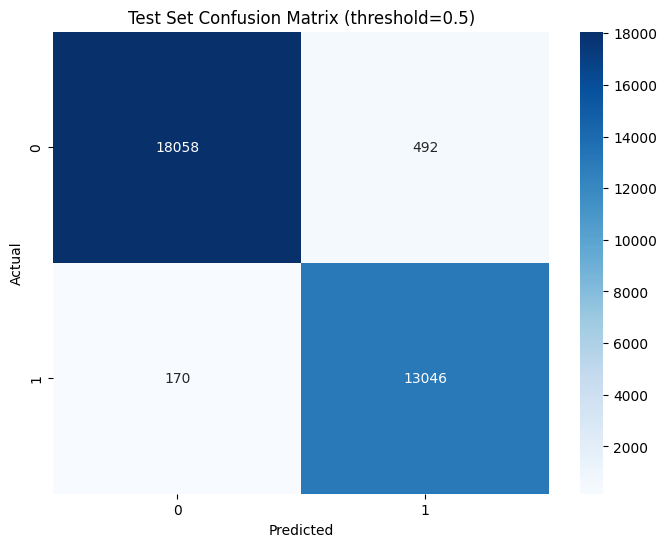

In [10]:
test_dataset = TensorDataset(
    torch.FloatTensor(X_emb_test),
    torch.FloatTensor(features_test),
    torch.FloatTensor(y_test)
)
test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False)

model.eval()
test_preds = []
test_labels = []
test_probs = []

with torch.no_grad():
    for embeddings, features, labels in test_loader:
        embeddings, features = embeddings.to(device), features.to(device)
        
        logits = model(embeddings, features).squeeze()
        probs = torch.sigmoid(logits)
        
        if probs.dim() == 0:
            test_probs.append(probs.cpu().item())
            test_labels.append(labels.item())
        else:
            test_probs.extend(probs.cpu().numpy())
            test_labels.extend(labels.numpy())

test_probs = np.array(test_probs)
test_labels = np.array(test_labels)
test_preds = (test_probs >= best_params['threshold']).astype(int)

test_metrics = {
    'accuracy': accuracy_score(test_labels, test_preds),
    'precision': precision_score(test_labels, test_preds, zero_division=0),
    'recall': recall_score(test_labels, test_preds, zero_division=0),
    'f1': f1_score(test_labels, test_preds, zero_division=0),
    'roc_auc': roc_auc_score(test_labels, test_probs)
}

print(f"Test Set Performance (threshold={best_params['threshold']}):")
print(f"Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall: {test_metrics['recall']:.4f}")
print(f"F1 Score: {test_metrics['f1']:.4f}")
print(f"ROC-AUC: {test_metrics['roc_auc']:.4f}")

wandb.log({
    "test/accuracy": test_metrics['accuracy'],
    "test/precision": test_metrics['precision'],
    "test/recall": test_metrics['recall'],
    "test/f1": test_metrics['f1'],
    "test/roc_auc": test_metrics['roc_auc'],
})

cm = confusion_matrix(test_labels, test_preds)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title(f'Test Set Confusion Matrix (threshold={best_params["threshold"]})')
wandb.log({"test/confusion_matrix": wandb.Image(fig)})
plt.show()
plt.close()

## Evaluate on External Set

External Set Performance (threshold=0.5):
Accuracy: 0.9379
Precision: 0.9626
Recall: 0.9215
F1 Score: 0.9416
ROC-AUC: 0.9818


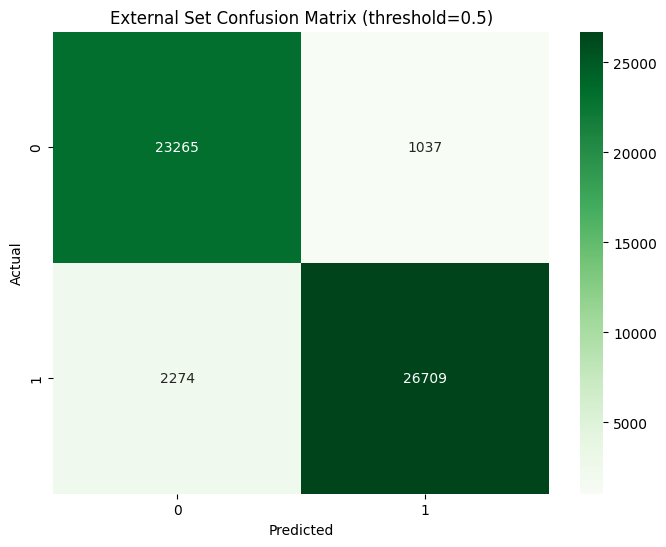

In [11]:
external_dataset = TensorDataset(
    torch.FloatTensor(X_emb_external),
    torch.FloatTensor(features_external),
    torch.FloatTensor(y_external)
)
external_loader = DataLoader(external_dataset, batch_size=best_params['batch_size'], shuffle=False)

ext_preds = []
ext_labels = []
ext_probs = []

with torch.no_grad():
    for embeddings, features, labels in external_loader:
        embeddings, features = embeddings.to(device), features.to(device)
        
        logits = model(embeddings, features).squeeze()
        probs = torch.sigmoid(logits)
        
        if probs.dim() == 0:
            ext_probs.append(probs.cpu().item())
            ext_labels.append(labels.item())
        else:
            ext_probs.extend(probs.cpu().numpy())
            ext_labels.extend(labels.numpy())

ext_probs = np.array(ext_probs)
ext_labels = np.array(ext_labels)
ext_preds = (ext_probs >= best_params['threshold']).astype(int)

external_metrics = {
    'accuracy': accuracy_score(ext_labels, ext_preds),
    'precision': precision_score(ext_labels, ext_preds, zero_division=0),
    'recall': recall_score(ext_labels, ext_preds, zero_division=0),
    'f1': f1_score(ext_labels, ext_preds, zero_division=0),
    'roc_auc': roc_auc_score(ext_labels, ext_probs)
}

print(f"External Set Performance (threshold={best_params['threshold']}):")
print(f"Accuracy: {external_metrics['accuracy']:.4f}")
print(f"Precision: {external_metrics['precision']:.4f}")
print(f"Recall: {external_metrics['recall']:.4f}")
print(f"F1 Score: {external_metrics['f1']:.4f}")
print(f"ROC-AUC: {external_metrics['roc_auc']:.4f}")
wandb.log({
    "external/accuracy": external_metrics['accuracy'],
    "external/precision": external_metrics['precision'],
    "external/recall": external_metrics['recall'],
    "external/f1": external_metrics['f1'],
    "external/roc_auc": external_metrics['roc_auc'],
})

cm = confusion_matrix(ext_labels, ext_preds)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title(f'External Set Confusion Matrix (threshold={best_params["threshold"]})')
wandb.log({"external/confusion_matrix": wandb.Image(fig)})
plt.show()
plt.close()

## Precision-Recall Curves

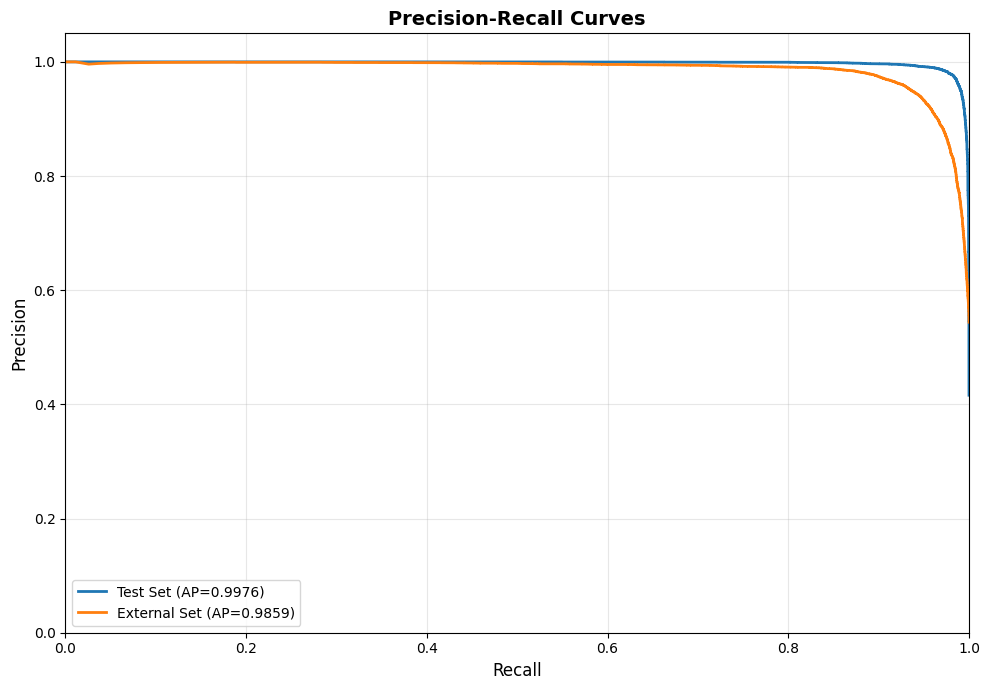

In [12]:
precision_test, recall_test, _ = precision_recall_curve(test_labels, test_probs)
precision_ext, recall_ext, _ = precision_recall_curve(ext_labels, ext_probs)

ap_test = average_precision_score(test_labels, test_probs)
ap_ext = average_precision_score(ext_labels, ext_probs)

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(recall_test, precision_test, label=f'Test Set (AP={ap_test:.4f})', linewidth=2)
ax.plot(recall_ext, precision_ext, label=f'External Set (AP={ap_ext:.4f})', linewidth=2)
ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Curves', fontsize=14, fontweight='bold')
ax.legend(loc='lower left', fontsize=10)
ax.grid(alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1.05])

plt.tight_layout()
wandb.log({"pr_curves": wandb.Image(fig)})
plt.show()
plt.close()

## Save Model and Results

In [13]:
os.makedirs("../../output/saved_models_dnnda", exist_ok=True)
os.makedirs("../../output/tuning_results_dnnda", exist_ok=True)

torch.save({
    'model_state_dict': model.state_dict(),
    'embedding_dim': config["embedding_dim"],
    'num_features': len(numeric_features),
    'feature_hidden_dim': best_params['feature_hidden_dim'],
    'dropout': best_params['dropout'],
    'best_params': best_params,
    'test_metrics': test_metrics,
    'external_metrics': external_metrics,
}, '../../output/saved_models_dnnda/mlp_hybrid.pth')

results = {
    'hyperparameters': best_params,
    'optuna_results': {
        'best_f2_score': study.best_trial.value,
        'recall': study.best_trial.user_attrs['recall'],
        'roc_auc': study.best_trial.user_attrs['roc_auc'],
        'precision': study.best_trial.user_attrs['precision'],
        'f1_score': study.best_trial.user_attrs['f1_score']
    },
    'test_performance': {k: float(v) for k, v in test_metrics.items()},
    'external_performance': {k: float(v) for k, v in external_metrics.items()},
    'config': config,
    'data_splits': {
        'train_size': len(train_df),
        'val_size': len(val_df),
        'test_size': len(test_df),
        'external_size': len(external_df)
    },
    'timestamp': datetime.now().isoformat()
}

with open('../../output/tuning_results_dnnda/mlp_results.json', 'w') as f:
    json.dump(results, f, indent=2)

artifact = wandb.Artifact('mlp-model', type='model')
artifact.add_file('../../output/saved_models_dnnda/mlp_hybrid.pth')
artifact.add_file('../../output/tuning_results_dnnda/mlp_results.json')
wandb.log_artifact(artifact)


<Artifact mlp-model>

In [14]:
wandb.finish()

batch_size,▁▃█▁▁█▃▃▃▁▃▃▃▃▃▃█▃▃█▃▃▃▃▃▃▃▃██
dropout,▁▃▅▁█▃▆█▁█▃▆▆▅▆▅▃▁▅▃▅▅▅▆▃▁▃▁▃▃
epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
external/accuracy,▁
external/f1,▁
external/precision,▁
external/recall,▁
external/roc_auc,▁
feature_hidden_dim,▂▁▂▄▄▄▂▄▁▄▁█▂▁█▁▁▁▁▁▁▁▁▁██████
lr,▁▂▁▂▅▂▁▂▂▄▃▁▁▃█▁▁▂▁▃▁▁▁▂▁▁▁▁▁▁
+13,...
